In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from torch.nn.utils import weight_norm
import torch.nn.init as weight_init
import random
def setup_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)  # cpu
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = True 
setup_seed(15)

In [2]:
import os
MODELS_WEIGHTS = os.environ.get("MODELS_WEIGHTS","/home/resifis/Desktop/kaustcode/Packages/models/weights/")


class TrainingConfig():
    def __init__(self,
                 model,
                 criterion,
                 optimizer,
                 scheduler,
                 device,
                 shuffle_trainloader,
                 train_batch_size,
                 shuffle_validloader,
                 valid_batch_size,
                 epoch,
                 verbose,
                 ):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.shuffle_trainloader = shuffle_trainloader
        self.train_batch_size = train_batch_size
        self.shuffle_validloader = shuffle_validloader
        self.valid_batch_size = valid_batch_size
        self.epoch = epoch
        self.verbose = verbose
        
        
    def _initialize_weights(self,m):
        if isinstance(m, nn.Conv3d):
            nn.init.kaiming_normal_(
                m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.MaxPool3d):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()


def create_window_3D(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t())
    _3D_window = _1D_window.mm(_2D_window.reshape(1, -1)).reshape(window_size, window_size, window_size).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_3D_window.expand(channel, 1, window_size, window_size, window_size).contiguous())
    return window
    
def _ssim_3D(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv3d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv3d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)

    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv3d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv3d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv3d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)
    


class SSIM3D(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM3D, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window_3D(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window_3D(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim_3D(img1, img2, window, self.window_size, channel, self.size_average)
    
    
    
    
class PSNR(torch.nn.Module):
    def __init__(self):
        super(PSNR,self).__init__()
        
    def _mse(self,im1,im2):
        mse = torch.nn.MSELoss()
        return mse(im1,im2)
    def forward(self,im1,im2):
        mse_loss = self._mse(im1,im2)
        max_ = im2.max()
        psnr_loss = 10 * torch.log10((max_**2)/mse_loss)
        return -psnr_loss
    
    
class Loss(nn.Module):
    def __init__(self,loss_name):
        super(Loss,self).__init__()
        self.mse = nn.MSELoss()
        self.l1  = nn.L1Loss()
        self.loss_name = loss_name
        self.psnr = PSNR()
        self.ssim = SSIM3D(window_size = 11)
        
    def forward(self,yhat,y):
        if self.loss_name == "RMSE":
            return torch.sqrt(self.mse(yhat,y))
        elif self.loss_name == "MSE":
            return self.mse(yhat,y)
        elif self.loss_name == "L1Loss":
            return self.l1(yhat,y)
        elif self.loss_name == "PSNR":
            return self.psnr(yhat,y)
        elif self.loss_name == "SSIM":
            return 1-self.ssim(yhat,y)

In [4]:
class Dataset():
    def __init__(self,data,window,cols):
        self.window = window
        self.data = data
        self.cols = cols
        self.new_data = Dataset.window_adder(self.data,self.window,self.cols)
        self.new_data = self.new_data.dropna()
        self.out = dict()
        self.out["data"] = Dataset.create_encoder(self.new_data,self.window,self.cols)
        self.out["target"] = torch.tensor(self.new_data["Ghi"].values,dtype = torch.float)
        
    @staticmethod 
    def window_adder(input_data,window,cols):
        data = input_data.copy()
        for i in range(1,window):
            for col in cols:
                feature_name = f"{col}(t = N - {i})"
                data[feature_name] = data[col].shift(i)
        return data
    @staticmethod           
    def create_encoder(data,window,cols):
        out = dict()
        for col in cols:
            feature_names = [f"{col}(t = N - {i})" for i in range(window-1,0,-1)]
            out[col] = data[feature_names].values
        x1 = torch.tensor(out[cols[0]],dtype = torch.float).unsqueeze(2)
        for feat in cols[1:]:
            x2 = torch.tensor(out[feat],dtype=torch.float).unsqueeze(2)
            x1 = torch.cat([x1,x2],dim = 2)
        return x1
    
    def __len__(self):
        return len(self.new_data)
    
    def __getitem__(self,item):
        output = dict()
        output["data"]  = self.out["data"][item]
        output["target"] = self.out["target"][item]
        return output
        

In [5]:
SPECPATH = os.environ.get("SPECPATH",'/home/resifis/Desktop/kaustcode/Packages/processed_data/one_location.csv')

In [6]:
data = pd.read_csv(SPECPATH)
data = data.set_index("Unnamed: 0")

In [7]:
data.head()

,aod,water_vapor,ozone,Ghi,cloud_high,cloud_low,cloud_med
Unnamed: 0,,,,,,,
0,0.101301,0.035554,0.000001,0.00000,0.0,0.0,0.0
1,0.101297,0.036175,0.000001,53.30044,0.0,0.0,0.0
2,0.101293,0.031825,0.000001,251.53429,0.0,0.0,0.0
3,0.101293,0.027508,0.000001,448.08932,0.0,0.0,0.0
4,0.101280,0.029158,0.000001,597.67535,0.0,0.0,0.0


In [8]:
data["mean_GHI_10"] = data["Ghi"].rolling(window = 10).mean()
data["mean_GHI_15"] = data["Ghi"].rolling(window = 15).mean()
data["std_GHI_10"] = data["Ghi"].rolling(window = 10).std()
data["std_GHI_15"] = data["Ghi"].rolling(window = 15).std()
data["mean_GHI_7"] = data["Ghi"].rolling(window = 7).mean()
data["mean_GHI_5"] = data["Ghi"].rolling(window = 5).mean()
data["std_GHI_7"] = data["Ghi"].rolling(window = 7).std()
data["std_GHI_5"] = data["Ghi"].rolling(window = 5).std()
data["mean_wv_10"] = data["water_vapor"].rolling(window = 10).mean()
data["mean_wv_15"] = data["water_vapor"].rolling(window = 15).mean()
data["std_wv_10"] = data["water_vapor"].rolling(window = 10).std()
data["std_wv_15"] = data["water_vapor"].rolling(window = 15).std()

data["mean_aod_10"] = data["aod"].rolling(window = 10).mean()
data["mean_aod_15"] = data["aod"].rolling(window = 15).mean()
data["mean_aod_5"] = data["aod"].rolling(window = 5).mean()
data["mean_aod_7"] = data["aod"].rolling(window = 7).mean()
data["std_aod_10"] = data["aod"].rolling(window = 10).std()
data["std_aod_15"] = data["aod"].rolling(window = 15).std()
data["std_aod_7"] = data["aod"].rolling(window = 7).std()
data["std_aod_5"] = data["aod"].rolling(window = 5).std()


data["mean_ozone_10"] = data["ozone"].rolling(window = 10).mean()
data["mean_ozone_15"] = data["ozone"].rolling(window = 15).mean()
data["mean_ozone_5"] = data["ozone"].rolling(window = 5).mean()
data["mean_ozone_7"] = data["ozone"].rolling(window = 7).mean()
data["std_ozone_10"] = data["ozone"].rolling(window = 10).std()
data["std_ozone_15"] = data["ozone"].rolling(window = 15).std()
data["std_ozone_7"] = data["ozone"].rolling(window = 7).std()
data["std_ozone_5"] = data["ozone"].rolling(window = 5).std()

data["mean_cloud_high_10"] = data["cloud_high"].rolling(window = 10).mean()
data["mean_cloud_high_15"] = data["cloud_high"].rolling(window = 15).mean()
data["mean_cloud_high_5"] = data["cloud_high"].rolling(window = 5).mean()
data["mean_cloud_high_7"] = data["cloud_high"].rolling(window = 7).mean()
data["std_cloud_high_10"] = data["cloud_high"].rolling(window = 10).std()
data["std_cloud_high_15"] = data["cloud_high"].rolling(window = 15).std()
data["std_cloud_high_7"] = data["cloud_high"].rolling(window = 7).std()
data["std_cloud_high_5"] = data["cloud_high"].rolling(window = 5).std()


data["mean_cloud_low_10"] = data["cloud_low"].rolling(window = 10).mean()
data["mean_cloud_low_15"] = data["cloud_low"].rolling(window = 15).mean()
data["mean_cloud_low_5"] = data["cloud_low"].rolling(window = 5).mean()
data["mean_cloud_low_7"] = data["cloud_low"].rolling(window = 7).mean()
data["std_cloud_low_10"] = data["cloud_low"].rolling(window = 10).std()
data["std_cloud_low_15"] = data["cloud_low"].rolling(window = 15).std()
data["std_cloud_low_7"] = data["cloud_low"].rolling(window = 7).std()
data["std_cloud_low_5"] = data["cloud_low"].rolling(window = 5).std()


data["mean_cloud_med_10"] = data["cloud_med"].rolling(window = 10).mean()
data["mean_cloud_med_15"] = data["cloud_med"].rolling(window = 15).mean()
data["mean_cloud_med_5"] = data["cloud_med"].rolling(window = 5).mean()
data["mean_cloud_med_7"] = data["cloud_med"].rolling(window = 7).mean()
data["std_cloud_med_10"] = data["cloud_med"].rolling(window = 10).std()
data["std_cloud_med_15"] = data["cloud_med"].rolling(window = 15).std()
data["std_cloud_med_7"] = data["cloud_med"].rolling(window = 7).std()
data["std_cloud_med_5"] = data["cloud_med"].rolling(window = 5).std()


data["prevGHI"] = data["Ghi"].shift(1)
data["GHI_changerate"] = (data["Ghi"]-data["Ghi"])/(data["Ghi"])



for i in range(1,25):
    data[f"GHI_lag{i}"] = data["Ghi"].shift(i)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()

In [9]:
cols = [col for col in data.columns.tolist() if "changerate" in col]
cols += [col for col in data.columns.tolist() if "lag" in col]
cols += [col for col in data.columns.tolist() if "mean" in col]
cols += [col for col in data.columns.tolist() if "std" in col]
cols += [col for col in data.columns.tolist() if "prev" in col]

In [10]:
train_data = data.iloc[:35000]
valid_data = data.iloc[35000:40000]
test_data = data.iloc[40000:]

In [11]:
trainset = Dataset(train_data,25,cols)
validset = Dataset(valid_data,25,cols)
testset = Dataset(test_data,25,cols)

In [12]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv2d(n_inputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.pad = torch.nn.ZeroPad2d((padding, 0, 0, 0))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2 = weight_norm(nn.Conv2d(n_outputs, n_outputs, (1, kernel_size),
                                           stride=stride, padding=0, dilation=dilation))
        self.net = nn.Sequential(self.pad, self.conv1, self.relu, self.dropout,
                                 self.pad, self.conv2, self.relu, self.dropout)
        self.downsample = nn.Conv1d(
            n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x.unsqueeze(2)).squeeze(2)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    
class TCNModel(nn.Module):
    def __init__(self, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(
            24, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.decoder = nn.Linear(num_channels[-1], 1)
    def forward(self, x):
        return self.decoder(self.dropout(self.tcn(x)[:, :, -1]))

In [13]:
Model = TCNModel([len(cols),256,128,64,32,16,8])

# Engine

In [14]:
criterion = Loss("RMSE")
optimizer = torch.optim.AdamW(Model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor = 0.2,
                                                       patience = 3,
                                                       verbose = True)

shuffle_trainloader = False
train_batch_size = 256
shuffle_validloader = False
valid_batch_size = 256
epoch = 200
verbose = True

In [15]:
device = torch.device("cuda:1")
train_config = TrainingConfig(Model,
                              criterion,
                              optimizer,
                              scheduler,
                              device,
                              shuffle_trainloader,
                              train_batch_size,
                              shuffle_validloader,
                              valid_batch_size,
                              epoch,
                              verbose,
                             )

In [16]:
from tqdm import tqdm
import torch
import os
from tqdm import tqdm
class AverageMeter:
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



class Training():
    def __init__(self,train_config):
        self.train_config = train_config
        
    def train_fn(self,model,train_loader):
        self.train_config.model.train()
        tr_loss = 0
        counter = 0
        losses = AverageMeter()
        tqt = tqdm(enumerate(train_loader),total = len(train_loader))
        for index,train_batch in tqt:
            data = train_batch["data"].to(self.train_config.device)
            target = train_batch["target"].to(self.train_config.device)
            self.train_config.optimizer.zero_grad()
            pred_target = model(data)
            train_loss = self.train_config.criterion(pred_target,target)
            tr_loss += train_loss.item()
            #backward probagation
            train_loss.backward()
            self.train_config.optimizer.step()
            counter = counter + 1
            losses.update(train_loss.item(),pred_target.size(0))
            tqt.set_postfix(loss = losses.avg, batch_number = index)
        return tr_loss/counter
                   
    def valid_fn(self,model,validation_loader):
        self.train_config.model.eval()
        val_loss = 0
        counter = 0
        losses = AverageMeter()
        tqt = tqdm(enumerate(validation_loader),total = len(validation_loader))
        with torch.no_grad():
            for index, valid_batch in tqt :
                data = valid_batch["data"].to(self.train_config.device)
                target = valid_batch["target"].to(self.train_config.device)
                pred_target = model(data)
                validation_loss = self.train_config.criterion(pred_target,target)
                val_loss += validation_loss.item()        
                counter = counter + 1
                losses.update(validation_loss.item(),pred_target.size(0))
                tqt.set_postfix(loss = losses.avg, batch_number = index)
        return val_loss/counter
    
    
    def fit(self,train_dataset,valid_dataset):
        
        train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                                        shuffle = self.train_config.shuffle_trainloader,
                                                        batch_size = self.train_config.train_batch_size,
                                                        num_workers = 4,
                                                       )
        valid_data_loader = torch.utils.data.DataLoader(valid_dataset,
                                                        shuffle = self.train_config.shuffle_validloader,
                                                        batch_size = self.train_config.valid_batch_size,
                                                        num_workers = 4,
                                                       )
        
        train_loss = []
        valid_loss = []
        best = 50000000
        for epoch in range(self.train_config.epoch):
            if self.train_config.verbose :
                print(f".........EPOCH {epoch}........")
            tr_loss = self.train_fn(self.train_config.model,train_data_loader)
            train_loss.append(tr_loss)
            if self.train_config.verbose :
                print(f".........Train Loss = {tr_loss}........")
            val_loss = self.valid_fn(self.train_config.model,valid_data_loader)
            valid_loss.append(val_loss)
            self.train_config.scheduler.step(val_loss)
            if self.train_config.verbose:
                print(f"...........Validation Loss = {val_loss}.......")
                
            if val_loss < best :
                best = val_loss
                patience = 0
            else:
                patience +=1
                
            if patience >= 5:
                print(f"Early Stopping on Epoch {epoch}")
                print(f"Best Loss = {best}")
                break
        PATH = 'model.pth'
        torch.save(self.train_config.model.state_dict(),PATH)
        self.train_config.model.load_state_dict(torch.load(PATH))

In [17]:
training = Training(train_config)
training.fit(trainset,validset)

.........EPOCH 0........


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [09:12<00:00,  4.03s/it, batch_number=136, loss=473]

.........Train Loss = 472.0813649866703........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:16<00:00,  3.83s/it, batch_number=19, loss=328]

...........Validation Loss = 326.97558135986327.......
.........EPOCH 1........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:49<00:00,  3.87s/it, batch_number=136, loss=353]

.........Train Loss = 352.5775019513429........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.75s/it, batch_number=19, loss=315]

...........Validation Loss = 314.0910980224609.......
.........EPOCH 2........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:47<00:00,  3.85s/it, batch_number=136, loss=343]

.........Train Loss = 342.9876702301694........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:15<00:00,  3.79s/it, batch_number=19, loss=321]

...........Validation Loss = 320.5525238037109.......
.........EPOCH 3........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [09:03<00:00,  3.97s/it, batch_number=136, loss=339]

.........Train Loss = 338.89500694553345........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:18<00:00,  3.90s/it, batch_number=19, loss=322]

...........Validation Loss = 321.0907928466797.......
.........EPOCH 4........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:52<00:00,  3.89s/it, batch_number=136, loss=337]

.........Train Loss = 336.69410906046846........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:15<00:00,  3.76s/it, batch_number=19, loss=317]

...........Validation Loss = 316.3674934387207.......
.........EPOCH 5........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:38<00:00,  3.78s/it, batch_number=136, loss=336]

.........Train Loss = 335.84384790128166........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:15<00:00,  3.78s/it, batch_number=19, loss=327]

Epoch     6: reducing learning rate of group 0 to 2.0000e-05.
...........Validation Loss = 325.50358657836915.......
.........EPOCH 6........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:30<00:00,  3.73s/it, batch_number=136, loss=334]

.........Train Loss = 334.1206981352646........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.75s/it, batch_number=19, loss=308]

...........Validation Loss = 306.8589553833008.......
.........EPOCH 7........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:42<00:00,  3.82s/it, batch_number=136, loss=334]

.........Train Loss = 333.69494706870864........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:11<00:00,  3.59s/it, batch_number=19, loss=306]

...........Validation Loss = 305.49038848876955.......
.........EPOCH 8........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:27<00:00,  3.70s/it, batch_number=136, loss=333]

.........Train Loss = 333.2041918900761........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.62s/it, batch_number=19, loss=306]

...........Validation Loss = 304.8344161987305.......
.........EPOCH 9........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:26<00:00,  3.70s/it, batch_number=136, loss=333]

.........Train Loss = 333.1832415726933........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.61s/it, batch_number=19, loss=306]

...........Validation Loss = 305.29601135253904.......
.........EPOCH 10........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:43<00:00,  3.82s/it, batch_number=136, loss=333]

.........Train Loss = 332.6368752361214........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:15<00:00,  3.75s/it, batch_number=19, loss=305]

...........Validation Loss = 303.8636901855469.......
.........EPOCH 11........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:29<00:00,  3.72s/it, batch_number=136, loss=333]

.........Train Loss = 332.5840846152201........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.61s/it, batch_number=19, loss=305]

...........Validation Loss = 303.72783813476565.......
.........EPOCH 12........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:28<00:00,  3.71s/it, batch_number=136, loss=333]

.........Train Loss = 332.86436428988935........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.61s/it, batch_number=19, loss=304]

...........Validation Loss = 303.44916915893555.......
.........EPOCH 13........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:29<00:00,  3.72s/it, batch_number=136, loss=332]

.........Train Loss = 332.05676147015424........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:15<00:00,  3.75s/it, batch_number=19, loss=304]

...........Validation Loss = 303.4764808654785.......
.........EPOCH 14........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:43<00:00,  3.82s/it, batch_number=136, loss=333]

.........Train Loss = 332.34745142581687........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.61s/it, batch_number=19, loss=306]

...........Validation Loss = 304.9657470703125.......
.........EPOCH 15........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:25<00:00,  3.69s/it, batch_number=136, loss=332]

.........Train Loss = 332.2263821789818........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:11<00:00,  3.59s/it, batch_number=19, loss=304]

...........Validation Loss = 303.512744140625.......
.........EPOCH 16........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:32<00:00,  3.74s/it, batch_number=136, loss=333]

.........Train Loss = 332.4817054915602........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:11<00:00,  3.58s/it, batch_number=19, loss=304]

...........Validation Loss = 303.3379585266113.......
.........EPOCH 17........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:47<00:00,  3.85s/it, batch_number=136, loss=332]

.........Train Loss = 331.65066773351964........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.74s/it, batch_number=19, loss=305]

...........Validation Loss = 303.83816680908205.......
.........EPOCH 18........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:29<00:00,  3.72s/it, batch_number=136, loss=332]

.........Train Loss = 332.0803237135393........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:11<00:00,  3.59s/it, batch_number=19, loss=304]

...........Validation Loss = 303.1976509094238.......
.........EPOCH 19........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:26<00:00,  3.69s/it, batch_number=136, loss=332]

.........Train Loss = 331.7600024146755........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.61s/it, batch_number=19, loss=303]

...........Validation Loss = 302.3306549072266.......
.........EPOCH 20........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:29<00:00,  3.72s/it, batch_number=136, loss=332]

.........Train Loss = 331.95045170470746........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.74s/it, batch_number=19, loss=304]

...........Validation Loss = 303.05323181152346.......
.........EPOCH 21........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:44<00:00,  3.83s/it, batch_number=136, loss=332]

.........Train Loss = 331.5519735517293........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.61s/it, batch_number=19, loss=303]

...........Validation Loss = 302.58623428344725.......
.........EPOCH 22........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:26<00:00,  3.70s/it, batch_number=136, loss=332]

.........Train Loss = 331.576764740213........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.62s/it, batch_number=19, loss=303]

...........Validation Loss = 302.0375473022461.......
.........EPOCH 23........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:26<00:00,  3.70s/it, batch_number=136, loss=331]

.........Train Loss = 331.22315511216215........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.61s/it, batch_number=19, loss=304]

...........Validation Loss = 302.68587799072264.......
.........EPOCH 24........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:42<00:00,  3.82s/it, batch_number=136, loss=331]

.........Train Loss = 331.1183256720104........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:15<00:00,  3.75s/it, batch_number=19, loss=303]

...........Validation Loss = 302.2691879272461.......
.........EPOCH 25........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:31<00:00,  3.73s/it, batch_number=136, loss=332]

.........Train Loss = 331.65521284785586........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.61s/it, batch_number=19, loss=304]

...........Validation Loss = 303.0549705505371.......
.........EPOCH 26........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:27<00:00,  3.70s/it, batch_number=136, loss=331]

.........Train Loss = 331.1813061567989........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:12<00:00,  3.61s/it, batch_number=19, loss=304]

Epoch    27: reducing learning rate of group 0 to 4.0000e-06.
...........Validation Loss = 302.9156326293945.......
.........EPOCH 27........



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [08:27<00:00,  3.71s/it, batch_number=136, loss=332]

.........Train Loss = 331.39296594327385........



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:15<00:00,  3.76s/it, batch_number=19, loss=304]

...........Validation Loss = 303.240299987793.......
Early Stopping on Epoch 27
Best Loss = 302.0375473022461


In [18]:
def predict(model,dataset,device):
    model.eval()
    testloader = torch.utils.data.DataLoader(dataset,
                                             shuffle = True,
                                             batch_size = 256,
                                             num_workers = 4)
    tqt = tqdm(enumerate(testloader),total = len(testloader))
    with torch.no_grad():
        for index,test_batch in tqt:
            testdata = test_batch["data"].to(device)
            testtarget = test_batch["target"].to(device)
            target = model(testdata)
            if index == 0:
                out = target
            else :
                out = torch.cat([out,target],dim = 0)
        return out.cpu().detach().numpy()

In [19]:
device = torch.device("cuda:1")

In [20]:
results = predict(train_config.model,testset,device)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:55<00:00,  3.73s/it]


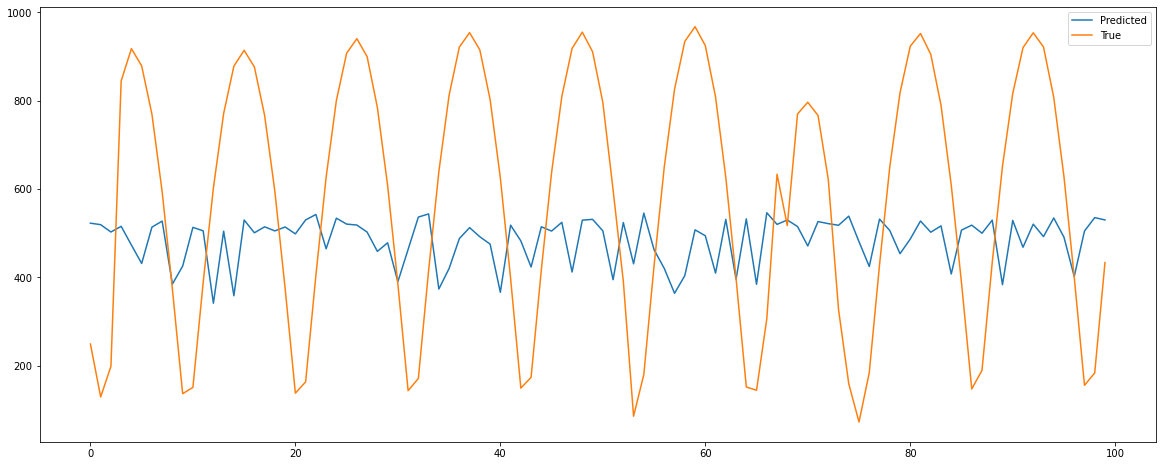

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,8))
plt.plot(results[:100],label = "Predicted")
plt.plot(testset.new_data["Ghi"].values[:100],label = "True")
plt.legend()